# Classification of drawings made in the game 'Quick, draw!'

Author: David Kradolfer, June 2017

In this project I will use scikit-learn and Keras to compare different machine learning algorithms to classify drawings made in the game ['Quick, draw!'](https://quickdraw.withgoogle.com/). In this game, people are told what they should draw in less than 20 seconds, while a neural network is predicting in real-time what it sees in the drawing. Once the prediction is correct, you can't finish your drawing, which might explain the rather minimalistic style of the drawings. It's not the most fun game, but certainly a great way of collecting data for machine learning. 

A huge dataset has been made publically available, more information is available in this [Github repository](https://github.com/googlecreativelab/quickdraw-dataset). I have used [this data](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1), which is already preprocessed to a uniform 28x28 pixel image size. Since the complete dataset includes over 50 million pictures and 345 categories, I will only use a small subset of it.


In [1]:
# Imports

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


## Binary Classification

I will start with only 2 classes, cat and sheep drawings. There data for each class consists of around 125'000 drawings (rows) and 784 pixels (columns) per drawing.

In [3]:
# load the data
cat = np.load('data/cat.npy')
sheep = np.load('data/sheep.npy')

print(cat.shape)
print(sheep.shape)

(123202, 784)
(126121, 784)


In [4]:
# add a column with labels, 0=cat, 1=sheep
cat = np.c_[cat, np.zeros(len(cat))]
sheep = np.c_[sheep, np.ones(len(sheep))]

Two useful functions: I wrote one to plot 28x28 pixel images from numpy arrays and will use one to plot the confusion matrix from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [5]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 5)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's take a look at some drawings. The quality and style of the drawings varies greatly, so we should expect a lower accuracy than in other tasks such as digit recognition. Also, the data set is not completely cleaned.

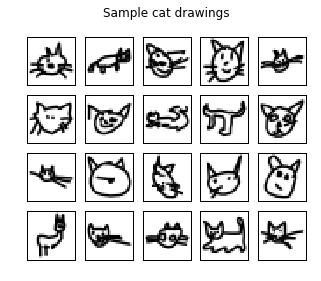

In [7]:
plot_samples(cat, title='Sample cat drawings\n')

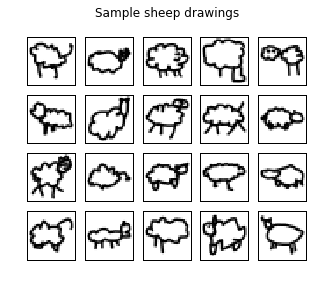

In [8]:
plot_samples(sheep, title='Sample sheep drawings\n')

Create the matrices for sklearn (5'000 cat and sheep images each):

In [9]:
# merge the cat and sheep arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((cat[:5000,:-1], sheep[:5000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((cat[:5000,-1], sheep[:5000,-1]), axis=0).astype('float32') # the last column

# train/test split (divide by 255 to obtain values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

## Random Forest

I will first try out a simple random forest classifier using the default options (except for random_state for reproducibility and n_jobs=-1 to use multiple CPUs):

In [10]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
print(clf_rf)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('Random forest accuracy: ',acc_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Random forest accuracy:  0.8672
Wall time: 440 ms


The most important argument, n_estimators (= number of trees in the forest), is set to 10 as a default. Let's try some larger values, as that should increase accuracy:

In [11]:
parameters = {'n_estimators': [10,20,40,60,80,100,120,140,160]}

In [12]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf = GridSearchCV(clf_rf, parameters, n_jobs=-1)
rf.fit(X_train, y_train)

results = pd.DataFrame(rf.cv_results_)

Wall time: 25.8 s


In [13]:
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,4.447982,0.375008,0.9160,1.0000,140,{'n_estimators': 140},1,0.915468,1.000000,0.914166,1.000000,0.918367,1.000000,0.102329,0.254840,0.001756,0.000000
6,3.796476,0.531260,0.9150,1.0000,120,{'n_estimators': 120},2,0.912470,1.000000,0.917167,1.000000,0.915366,1.000000,0.210763,0.331706,0.001935,0.000000
8,4.724030,0.510423,0.9150,1.0000,160,{'n_estimators': 160},2,0.914269,1.000000,0.914166,1.000000,0.916567,1.000000,0.352252,0.326347,0.001108,0.000000
5,2.979470,0.671882,0.9148,1.0000,100,{'n_estimators': 100},4,0.913669,1.000000,0.914166,1.000000,0.916567,1.000000,0.242931,0.242398,0.001265,0.000000
4,2.776787,0.229768,0.9130,1.0000,80,{'n_estimators': 80},5,0.913669,1.000000,0.910564,1.000000,0.914766,1.000000,0.076168,0.077154,0.001779,0.000000
3,1.859189,0.605114,0.9102,1.0000,60,{'n_estimators': 60},6,0.908873,1.000000,0.909964,1.000000,0.911765,1.000000,0.304365,0.614956,0.001192,0.000000
2,1.147876,0.650083,0.9062,1.0000,40,{'n_estimators': 40},7,0.904676,1.000000,0.906963,1.000000,0.906963,1.000000,0.277549,0.391239,0.001078,0.000000
1,0.751366,0.294448,0.8968,0.9999,20,{'n_estimators': 20},8,0.895084,1.000000,0.891957,0.999700,0.903361,1.000000,0.120386,0.120280,0.004811,0.000141
0,0.219220,0.156994,0.8838,0.9963,10,{'n_estimators': 10},9,0.881894,0.996098,0.873349,0.996401,0.896158,0.996401,0.071416,0.030650,0.009407,0.000142


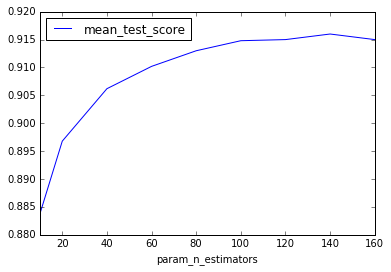

In [14]:
results.plot('param_n_estimators','mean_test_score');

The accuracy plateaus after about 100 trees, I will therefore use this parameter from here on.

We can also try to optimize the option 'max_features', which is the number of features to consider when looking for the best split. But as shown below, there are hardly any differences in the test scores (and the results are inconsistent, depending on the random state). I will therefore just keep the 'auto' option. 

In [15]:
parameters = {'max_features' : ['auto', 15, 28, 50] } # 28 = sqrt(784), which is suggested in the documentation as a good value

clf_rf = RandomForestClassifier(n_estimators= 100, n_jobs=-1, random_state=0)
rf = GridSearchCV(clf_rf, parameters, n_jobs=-1)
rf.fit(X_train, y_train)

results = pd.DataFrame(rf.cv_results_)
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.171569,0.850547,0.9168,1.0,15,{'max_features': 15},1,0.913070,1.0,0.920768,1.0,0.916567,1.0,0.256557,0.210139,0.003148,0.0
0,2.860953,0.565878,0.9148,1.0,auto,{'max_features': 'auto'},2,0.913669,1.0,0.914166,1.0,0.916567,1.0,0.686137,0.580566,0.001265,0.0
2,3.067822,0.882040,0.9148,1.0,28,{'max_features': 28},2,0.913669,1.0,0.914166,1.0,0.916567,1.0,0.557978,0.319956,0.001265,0.0
3,4.939714,0.385422,0.9134,1.0,50,{'max_features': 50},4,0.907674,1.0,0.912965,1.0,0.919568,1.0,0.352807,0.268927,0.004866,0.0


Let's run the random forest again with the selected options:

In [16]:
%%time

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('Random forest accuracy: ',acc_rf)

Random forest accuracy:  0.9044
Wall time: 1.56 s


We can visualize the model to see which pixels had the highest importance:

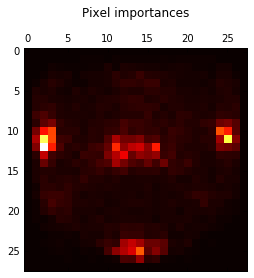

In [17]:
importances = clf_rf.feature_importances_
importances = importances.reshape((28,28))
plt.matshow(importances, cmap=plt.cm.hot);
plt.title('Pixel importances\n');

As could be expected, corners have a very low importance, as they are mostly blank. The left, right, middle and bottom part of the picture are most important. Looking at the pictures of cats and sheeps, it seems that the middle is mostly blank in sheeps, but not in cats. So pixels there probably indicate a cat image. The other 'hot' areas are less clear to me after a quick inspection of the images.

## K-Nearest Neighbors (KNN)

Next, I will try out a KNN classifier:

In [18]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
print(clf_knn)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
KNN accuracy:  0.9218
Wall time: 14.4 s


The KNN classifier looks promising, let's test out different values of K:

In [19]:
%%time

parameters = {'n_neighbors': [1,3,5,7,9]}

clf_knn = KNeighborsClassifier(n_jobs=-1)
knn = GridSearchCV(clf_knn, parameters, n_jobs=-1)
knn.fit(X_train, y_train)

results_knn = pd.DataFrame(knn.cv_results_)

Wall time: 2min 6s


In [20]:
results_knn.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,1.026882,11.224287,0.9216,0.9444,5,{'n_neighbors': 5},1,0.921463,0.944778,0.920768,0.943611,0.922569,0.944811,0.317530,0.672768,0.000741,0.000558
3,0.854179,11.294744,0.9210,0.9375,7,{'n_neighbors': 7},2,0.917866,0.937275,0.922569,0.938812,0.922569,0.936413,0.213987,0.271776,0.002218,0.000992
4,0.916679,9.458474,0.9200,0.9333,9,{'n_neighbors': 9},3,0.919664,0.931573,0.925570,0.934013,0.914766,0.934313,0.205055,0.076901,0.004416,0.001227
1,0.609385,11.018163,0.9188,0.9543,3,{'n_neighbors': 3},4,0.916067,0.952881,0.919568,0.955909,0.920768,0.954109,0.067509,0.517941,0.001995,0.001243
0,0.442717,10.651199,0.9098,1.0000,1,{'n_neighbors': 1},5,0.911871,1.000000,0.904562,1.000000,0.912965,1.000000,0.102329,0.681365,0.003730,0.000000


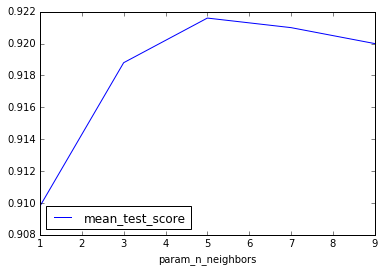

In [21]:
results_knn.plot('param_n_neighbors','mean_test_score');

The default option of k=5 seems to be optimal.
The KNN classifier is quite a bit more accurate than the random forest, but it also takes much longer (particularly the classification of new examples).

## Support Vector Machines (SVMs)

There are different implementations of SVMs in scikit-learn, I will try out three of them, the first two are linear SVMs, the third is a non linear:

In [22]:
%%time

clf_sgd = SGDClassifier(loss='hinge', random_state=0) # loss='hinge' results in a linear SVM
clf_sgd.fit(X_train, y_train)
print(clf_sgd)
y_pred_sgd = clf_sgd.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
print ('SVM stochastic gradient descent accuracy: ',acc_sgd)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)
SVM stochastic gradient descent accuracy:  0.8356
Wall time: 88.9 ms


In [23]:
%%time

clf_svm = LinearSVC(random_state=0)
clf_svm.fit(X_train, y_train)
print(clf_svm)
y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print ('Linear SVM accuracy: ',acc_svm)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)
Linear SVM accuracy:  0.8488
Wall time: 2.13 s


In [24]:
%%time

clf_svm = SVC(kernel='rbf', random_state=0) # using the Gaussian radial basis function
clf_svm.fit(X_train, y_train)
print(clf_svm)
y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print ('RBF SVM accuracy: ',acc_svm)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
RBF SVM accuracy:  0.8768
Wall time: 18.7 s


The SVMs seem not very promising. There are of course many parameters that could be optimized, but I will focus on other methods here.

##  Multi-Layer Perceptron (MLP)

Let's try out a simple neural network in scikit-learn:

In [25]:
%%time

clf_mlp = MLPClassifier(random_state=0)
clf_mlp.fit(X_train, y_train)
print(clf_mlp)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('mlp accuracy: ',acc_mlp)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
mlp accuracy:  0.9196
Wall time: 10.1 s


Compare different hidden_layer_sizes:

In [26]:
parameters = {'hidden_layer_sizes' : [(50,), (100,), (784,), (50,50), (100,100), (784,784), (50,50,50), (100,100,100)] }

clf_mlp = MLPClassifier(random_state=0)
mlp = GridSearchCV(clf_mlp, parameters, n_jobs=-1)
mlp.fit(X_train, y_train)

results=pd.DataFrame(mlp.cv_results_)
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hidden_layer_sizes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,84.443437,0.125001,0.9316,1.0,"(784,)","{'hidden_layer_sizes': (784,)}",1,0.921463,1.0,0.933974,1.0,0.939376,1.0,5.695825,2.973602e-07,0.007504,0.0
5,68.197884,0.234379,0.9312,1.0,"(784, 784)","{'hidden_layer_sizes': (784, 784)}",2,0.923861,1.0,0.935174,1.0,0.934574,1.0,2.114042,1.275688e-02,0.005198,0.0
1,24.661083,0.036383,0.9248,1.0,"(100,)","{'hidden_layer_sizes': (100,)}",3,0.915468,1.0,0.930972,1.0,0.927971,1.0,1.814210,7.418953e-03,0.006716,0.0
4,12.432924,0.040385,0.9224,1.0,"(100, 100)","{'hidden_layer_sizes': (100, 100)}",4,0.915468,1.0,0.927371,1.0,0.924370,1.0,0.398543,6.646391e-03,0.005056,0.0
3,12.352112,0.031252,0.9196,1.0,"(50, 50)","{'hidden_layer_sizes': (50, 50)}",5,0.917866,1.0,0.916567,1.0,0.924370,1.0,0.614647,1.697076e-06,0.003413,0.0
0,18.844031,0.026041,0.9186,1.0,"(50,)","{'hidden_layer_sizes': (50,)}",6,0.914269,1.0,0.923770,1.0,0.917767,1.0,0.506314,7.365920e-03,0.003924,0.0
7,8.246917,0.031251,0.9180,1.0,"(100, 100, 100)","{'hidden_layer_sizes': (100, 100, 100)}",7,0.914868,1.0,0.920768,1.0,0.918367,1.0,1.679368,5.947204e-07,0.002423,0.0
6,11.781441,0.036458,0.9158,1.0,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",8,0.911871,1.0,0.916567,1.0,0.918968,1.0,0.361459,7.365358e-03,0.002948,0.0


The larger neural nets with one or two layers of 784 (= number of input pixels) have clearly the highest accuracy. However, they also take a very long training time. I will therefore continue with the (100, 100) size, which is much faster and still has quite a high accuracy.

I will test as well different learning rates alpha:

In [27]:
parameters = {'alpha' : list(10.0 ** -np.arange(1, 7)) }

clf_mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=0)
mlp = GridSearchCV(clf_mlp, parameters, n_jobs=-1)
mlp.fit(X_train, y_train)

results=pd.DataFrame(mlp.cv_results_)
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,10.133306,0.033177,0.9238,1.0,0.001,{'alpha': 0.001},1,0.918465,1.0,0.929172,1.0,0.923770,1.0,0.303330,0.002724,0.004371,0.0
5,9.302874,0.026041,0.9234,1.0,1e-06,{'alpha': 1e-06},2,0.918465,1.0,0.927371,1.0,0.924370,1.0,0.400349,0.007366,0.003700,0.0
3,10.218442,0.038717,0.9224,1.0,0.0001,{'alpha': 0.0001},3,0.915468,1.0,0.927371,1.0,0.924370,1.0,0.287409,0.006400,0.005056,0.0
4,10.216297,0.041666,0.9220,1.0,1e-05,{'alpha': 1e-05},4,0.917866,1.0,0.926771,1.0,0.921369,1.0,0.335123,0.007362,0.003663,0.0
1,11.272396,0.032842,0.9216,1.0,0.01,{'alpha': 0.01},5,0.918465,1.0,0.927371,1.0,0.918968,1.0,0.412518,0.002250,0.004085,0.0
0,33.185462,0.036455,0.9202,1.0,0.1,{'alpha': 0.1},6,0.912470,1.0,0.926170,1.0,0.921969,1.0,1.393498,0.007367,0.005732,0.0


Let's use the model with the selected parameters to test its accuracy on the test set:

In [28]:
%%time

clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(100,100), random_state=0)
clf_mlp.fit(X_train, y_train)
print(clf_mlp)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('MLP accuracy: ',acc_mlp)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLP accuracy:  0.9202
Wall time: 5.11 s


The MLPC classifier gives a similar accuracy as KNN, but is a bit faster.

## Convolutional Neural Network (CNN)

Let's try out a Convolutional Neural Network (CNN) with Keras. I will use a model from this [tutorial](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/).

Keras requires one hot encoding of the y labels:

In [29]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

We also need to reshape the images to the original 28x28 shape, which gives the neural net additional information compared to a 784x1 vector.

In [30]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [31]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
%%time

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 23s - loss: 0.5168 - acc: 0.7732 - val_loss: 0.3468 - val_acc: 0.8438
Epoch 2/10
5000/5000 [==============================] - 23s - loss: 0.2812 - acc: 0.8842 - val_loss: 0.2475 - val_acc: 0.9072
Epoch 3/10
5000/5000 [==============================] - 24s - loss: 0.2207 - acc: 0.9130 - val_loss: 0.2016 - val_acc: 0.9212
Epoch 4/10
5000/5000 [==============================] - 23s - loss: 0.1796 - acc: 0.9316 - val_loss: 0.1792 - val_acc: 0.9290
Epoch 5/10
5000/5000 [==============================] - 23s - loss: 0.1692 - acc: 0.9364 - val_loss: 0.1746 - val_acc: 0.9308
Epoch 6/10
5000/5000 [==============================] - 23s - loss: 0.1526 - acc: 0.9440 - val_loss: 0.1627 - val_acc: 0.9374
Epoch 7/10
5000/5000 [==============================] - 23s - loss: 0.1412 - acc: 0.9464 - val_loss: 0.1514 - val_acc: 0.9400
Epoch 8/10
5000/5000 [==============================] - 23s - loss: 0.

As expected for an image classification task, the CNN has a very high accuracy with over 94%. But it also required the longest training time.

Let's take a closer look at the predictions it made:

In [33]:
y_pred_cnn = model_cnn.predict_classes(X_test_cnn, verbose=0)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print ('CNN accuracy: ',acc_cnn)

CNN accuracy:  0.9416


Confusion matrix, without normalization
[[2373  109]
 [ 183 2335]]


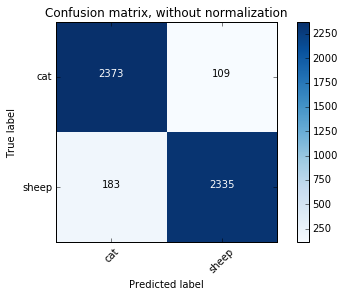

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['cat','sheep'],
                      title='Confusion matrix, without normalization')

plt.show()

To see some of the images that were misclassified, I will select them:

In [35]:
sheeps_not_cats = X_test[y_test > y_pred_cnn] # true: 1 (sheep), predicted: 0 (cat)
cats_not_sheeps = X_test[y_test < y_pred_cnn] # true: 0 (cat), predicted: 1 (sheep)

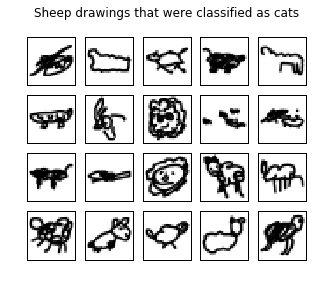

In [36]:
plot_samples(sheeps_not_cats, title = 'Sheep drawings that were classified as cats\n')

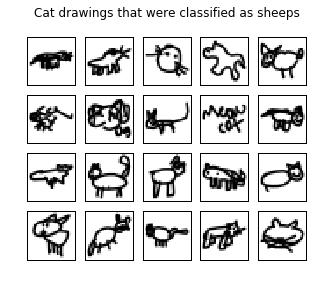

In [37]:
plot_samples(cats_not_sheeps, title = 'Cat drawings that were classified as sheeps\n')

Most of these drawings are really hard to classify, while some seem possible. But I only trained the CNN on 5'000 examples, so over 94% accuracy is quite respectable. In the next section I will increase the number of training examples up to 15'000, which gives an accuracy of over 96%.

As a further evaluation of the classifier, I will draw the ROC curve and calculate the Area Under the Curve (AUC):

In [38]:
# store the predicted probabilities for class 1 (sheep)
y_pred_prob = model_cnn.predict_proba(X_test_cnn, verbose=0)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

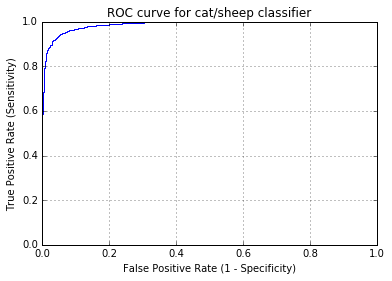

In [39]:
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for cat/sheep classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [40]:
# calculate AUC score:
roc_auc_score(y_test, y_pred_prob)

0.98769360203632961

The AUC score is very high, almost 99%.

## Comparison of different methods

Finally, I will compare the most promising algorithms using different numbers of training examples.

In [42]:
%%time

np.random.seed(0)

N_train = [500, 2000, 5000, 10000, 15000] # the number of training examples to be used
acc_scores = pd.DataFrame()

for i in N_train:
    # preprocessing as before with different sample sizes:
    X = np.concatenate((cat[:i,:-1], sheep[:i,:-1]), axis=0).astype('float32') 
    y = np.concatenate((cat[:i,-1], sheep[:i,-1]), axis=0).astype('float32') 
    X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)
    
    # run the different scikit-learn models:
    clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    acc_rf = clf_rf.score(X_test,y_test)
    acc_scores.set_value('RF', i, acc_rf)
    
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    clf_knn.fit(X_train, y_train)
    acc_knn = clf_knn.score(X_test,y_test)
    acc_scores.set_value('KNN', i, acc_knn)

    clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,50))
    clf_mlp.fit(X_train, y_train)
    acc_mlp = clf_mlp.score(X_test,y_test)
    acc_scores.set_value('MLP', i, acc_mlp)
    
    
    # preprocessing for keras:
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    
    # run the keras model:
    model = cnn_model()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=0)
    scores = model.evaluate(X_test, y_test, verbose=0)
    acc_scores.set_value('CNN', i, scores[1])
    

Wall time: 29min 35s


In [43]:
acc_scores

,500,2000,5000,10000,15000
RF,0.868,0.9030,0.8992,0.9210,0.926867
KNN,0.862,0.9060,0.9218,0.9322,0.936400
MLP,0.860,0.8945,0.9140,0.9299,0.932933
CNN,0.892,0.9285,0.9384,0.9566,0.961067


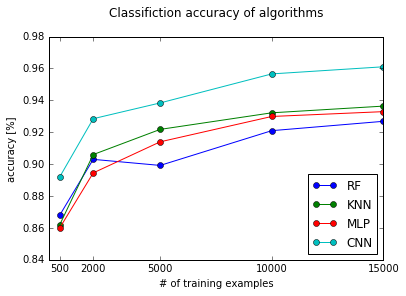

In [44]:
acc_scores.transpose().plot(xticks=list(acc_scores), xlim=(0,15000), marker='o', title='Classifiction accuracy of algorithms\n');
plt.xlabel('# of training examples');
plt.ylabel('accuracy [%]');

## Multi-class Classification

Now let's make the classification a bit more difficult by comparing 5 classes:

In [45]:
# load the data
dog = np.load('data/dog.npy')
octopus = np.load('data/octopus.npy')
bee = np.load('data/bee.npy')
hedgehog = np.load('data/hedgehog.npy')
giraffe = np.load('data/giraffe.npy')

The data preprocessing is similar as in the case for 2 classes:

In [46]:
# add a column with labels
dog = np.c_[dog, np.zeros(len(dog))]
octopus = np.c_[octopus, np.ones(len(octopus))]
bee = np.c_[bee, 2*np.ones(len(bee))]
hedgehog = np.c_[hedgehog, 3*np.ones(len(hedgehog))]
giraffe = np.c_[giraffe, 4*np.ones(len(giraffe))]

# store the label codes in a dictionary
label_dict = {0:'dog', 1:'octopus', 2:'bee', 3:'hedgehog', 4:'giraffe'}

print(dog.shape)
print(octopus.shape)
print(bee.shape)
print(hedgehog.shape)
print(giraffe.shape)

(152159, 785)
(150152, 785)
(120890, 785)
(120527, 785)
(127182, 785)


Create the matrices for sklearn (5'000 images per class):

In [47]:
X = np.concatenate((dog[:5000,:-1], octopus[:5000,:-1], bee[:5000,:-1], hedgehog[:5000,:-1], giraffe[:5000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((dog[:5000,-1], octopus[:5000,-1], bee[:5000,-1], hedgehog[:5000,-1], giraffe[:5000,-1]), axis=0).astype('float32') # the last column

X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

Use different scikit-learn algorithms to make predictions:

In [48]:
%%time

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.79104
Wall time: 4.55 s


In [64]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.8236
Wall time: 1min 22s


In [49]:
%%time

clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(100,100), random_state=0)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('mlp accuracy: ',acc_mlp)

mlp accuracy:  0.81176
Wall time: 23.8 s


Preprocessing for keras:

In [50]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [51]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [52]:
%%time

# build the model
model = cnn_model()
# Fit the model
model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 57s - loss: 1.0365 - acc: 0.6016 - val_loss: 0.6576 - val_acc: 0.7686
Epoch 2/10
12500/12500 [==============================] - 57s - loss: 0.6567 - acc: 0.7678 - val_loss: 0.5451 - val_acc: 0.8106
Epoch 3/10
12500/12500 [==============================] - 57s - loss: 0.5555 - acc: 0.8042 - val_loss: 0.4616 - val_acc: 0.8441
Epoch 4/10
12500/12500 [==============================] - 61s - loss: 0.4769 - acc: 0.8331 - val_loss: 0.4081 - val_acc: 0.8654
Epoch 5/10
12500/12500 [==============================] - 60s - loss: 0.4185 - acc: 0.8578 - val_loss: 0.3751 - val_acc: 0.8749
Epoch 6/10
12500/12500 [==============================] - 60s - loss: 0.3819 - acc: 0.8723 - val_loss: 0.3650 - val_acc: 0.8806
Epoch 7/10
12500/12500 [==============================] - 59s - loss: 0.3603 - acc: 0.8801 - val_loss: 0.3443 - val_acc: 0.8873
Epoch 8/10
12500/12500 [==============================

Let's take a look at the predictions of the CNN:

In [53]:
y_pred_cnn = model.predict_classes(X_test_cnn, batch_size=32, verbose=0)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print ('CNN accuracy: ',acc_cnn)

CNN accuracy:  0.90384


Confusion matrix, without normalization
[[2128   68  129  109   59]
 [  52 2365   65   42    7]
 [  86   81 2181  131   13]
 [ 100   37   83 2251   11]
 [  76   19   20   14 2373]]


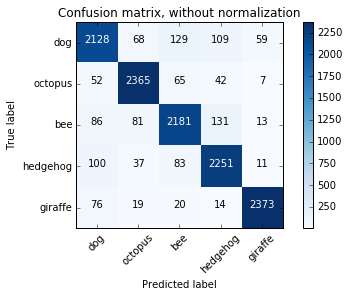

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['dog','octopus','bee','hedgehog','giraffe'],
                      title='Confusion matrix, without normalization')

plt.show()

Let's see what probabilities were predicted by the model:

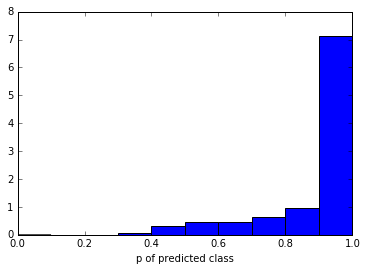

In [61]:
cnn_probab = model.predict(X_test_cnn, batch_size=32, verbose=0)

# extract the probability for the label that was predicted:
p_max = np.amax(cnn_probab, axis=1)

plt.hist(p_max, normed=True, bins=list(np.linspace(0,1,11)));
plt.xlabel('p of predicted class');

For about 70% of the pictures, the CNN predicted the label with > 90% certainty.

If the predictions of the CNN are well calibrated, the average prediction certainty should be equal to the accuracy (90%), which is indeed the case:

In [56]:
np.mean(p_max)

0.89950764

The lowest certainty of a prediction is about 25%:

In [57]:
np.amin(p_max)

0.26455301

Let's take a look at some predictions in detail:

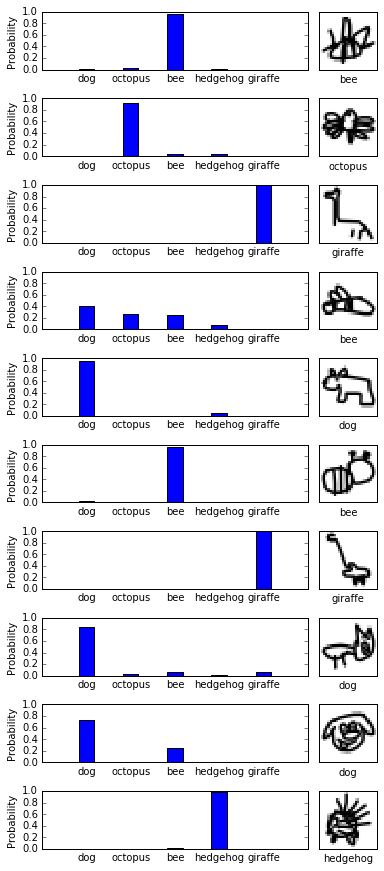

In [58]:
fig, ax = plt.subplots(figsize=(6,15))

for i in list(range(10)):

    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(5), ['dog','octopus','bee','hedgehog','giraffe'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])

Let's take a look at some pictures where the CNN was very unsure about the label by filtering with [p_max<0.4]:

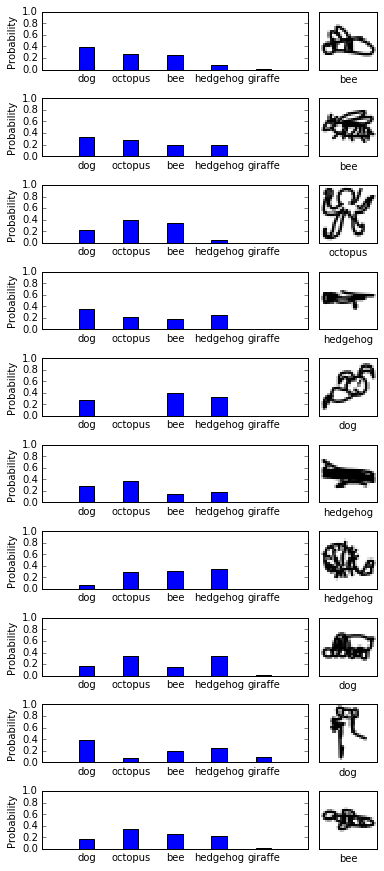

In [59]:
fig, ax = plt.subplots(figsize=(6,15))

for i in list(range(10)):
    
    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[p_max<0.4][i], 0.35, align='center');
    plt.xticks(np.arange(5), ['dog','octopus','bee','hedgehog','giraffe'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[p_max<0.4][i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[p_max<0.4][i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])

It seems that there is still some room for improvement. Notably, I have used just about 2% of the pictures for training. By increasing that number, big increases in accuracy would certainly be possible.